This notebook addresses a job shop scheduling problem. The objective studied is minimizing the completion time of latest job (makespan).

Jobs need to be scheduled on *m* parallel machines. Each job is associated with a set of operations which need to be processed in a specific order (known as precedence constraints). Each operation has a specific machine that it needs to be processed on, only one operation in a job can be processed at a given time and machines can only process one job at a time. 

This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs =10
jobs_list = [*range(0, nbrOfJobs)] 

In [2]:
nbrOfMachines = 3
machines_list = [*range(0, nbrOfMachines)] 

In [3]:
#randomly generate set of operations with assigned machine for each job
import random
minNbrOfOpsPerJob=1
maxNbrOfOpsPerJob=3
NbrofOps_list = [random.randint(minNbrOfOpsPerJob, maxNbrOfOpsPerJob) for j in jobs_list]
ops_mch=[[*range(0, NbrofOps_list[j])] for j in jobs_list] 
ops_duration=[[*range(0, NbrofOps_list[j])] for j in jobs_list] 
minProcessingTime=10
maxProcessingTime=40
for j in jobs_list:
    machine_sequence=random.sample(machines_list, NbrofOps_list[j])
    for o in range(0, NbrofOps_list[j]):
        ops_mch[j][o]=machine_sequence[o]
        ops_duration[j][o]=random.randint(minProcessingTime, maxProcessingTime)
print(ops_mch)
print(ops_duration)

[[1], [0, 2, 1], [2, 0], [0, 1], [0, 1], [2, 0, 1], [2, 1, 0], [1], [2, 0, 1], [1]]
[[39], [10, 32, 16], [31, 37], [33, 40], [15, 15], [34, 11, 11], [33, 20, 33], [29], [37, 22, 13], [17]]


In [4]:
from docplex.cp.model import *
mdl = CpoModel(name='parallelMachineScheduling_JobShop') 

In [5]:
# define production processing interval of each job at each machine
ops_itv_vars = [[mdl.interval_var(size=ops_duration[j][o], name="interval_job{}_operation{}".format(j,o)) for o in range(0, NbrofOps_list[j])] for j in jobs_list] 

In [6]:
#minimize makespan
objective = mdl.max([mdl.end_of(ops_itv_vars[j][NbrofOps_list[j]-1]) for j in jobs_list])
mdl.add(mdl.minimize(objective)) 

In [7]:
# Each operation must start after the end of the previous
for j in jobs_list:
    for o in range(1, NbrofOps_list[j]):
        mdl.add(mdl.end_before_start(ops_itv_vars[j][o - 1], ops_itv_vars[j][o]))

In [8]:
# Force no overlap for operations executed on the same machine
machine_operations = [[] for m in machines_list]
for j in jobs_list:
    for o in range(0, NbrofOps_list[j]):
        machine_operations[ops_mch[j][o]].append(ops_itv_vars[j][o])
for mops in machine_operations:
    mdl.add(mdl.no_overlap(mops))

In [9]:
msol= mdl.solve(log_output=True)

In [10]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 14, variables: integer: 0, interval: 21, sequence: 3
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.18 sec
-------------------------------------------------------------------------------
Objective values: (200,), bounds: (200,), gaps: (0,)
interval_job0_operation0: (start=61, end=100, size=39, length=39)
interval_job1_operation0: (start=0, end=10, size=10, length=10)
interval_job1_operation1: (start=135, end=167, size=32, length=32)
interval_job1_operation2: (start=171, end=187, size=16, length=16)
interval_job2_operation0: (start=0, end=31, size=31, length=31)
interval_job2_operation1: (start=58, end=95, size=37, length=37)
interval_job3_operation0: (start=25, end=58, size=33, length=33)
interval_job3_operation1: (start=131, end=171, size=40, length=40)
interval_job4_operation0: (sta

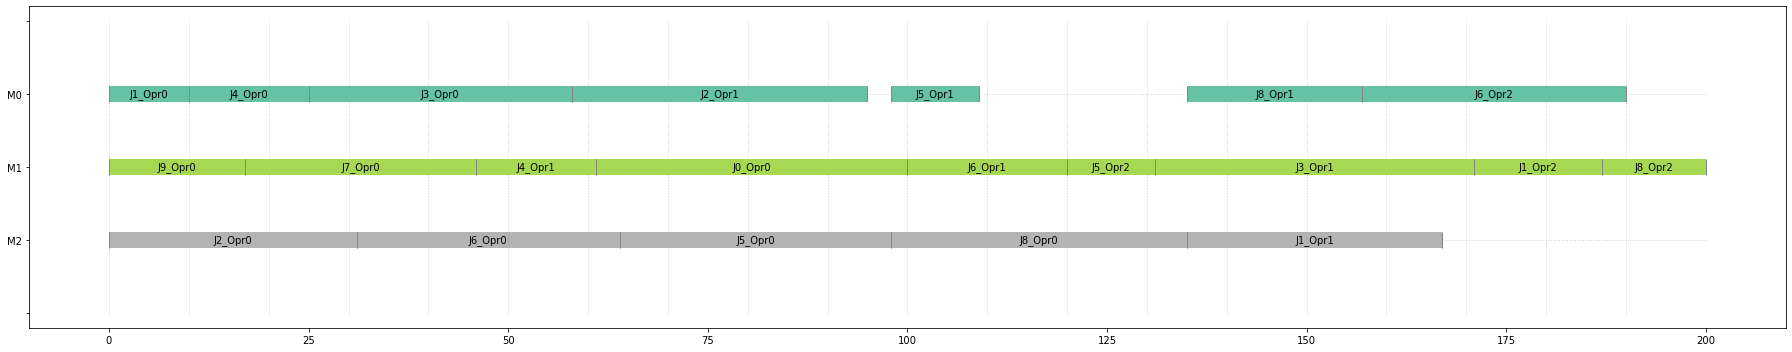

In [11]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for m in machines_list:
        visu.sequence(name='M' + str(m))
        for j in jobs_list:
            for o in range(0, NbrofOps_list[j]):
                itv = msol.get_var_solution(ops_itv_vars[j][o])
                if itv.is_present() and ops_mch[j][o]==m:
                    visu.interval(itv,m,'J' + str(j) + '_Opr' + str(o))
    visu.show()